In [1]:
import pandas as pd

# getting the dataset from files
train_df = pd.read_csv('./data/toxic_train.csv')
test_df = pd.read_csv('./data/toxic_test.csv')

In [2]:
# eliminating unnecessary column
train_df = train_df.drop(columns=['Unnamed: 0'])
train_df

,comment_text,toxic
0,Explanation\r\nWhy the edits made under my use...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \r\n\r\nThat...,0
159568,"Spitzer \r\n\r\nUmm, theres no actual article ...",0
159569,And it looks like it was actually you who put ...,0


In [3]:
test_df = test_df.drop(columns=['Unnamed: 0'])
test_df

,comment_text,toxic
0,Thank you for understanding. I think very high...,0
1,:Dear god this site is horrible.,0
2,"""::: Somebody will invariably try to add Relig...",0
3,""" \r\n\r\n It says it right there that it IS a...",0
4,""" \r\n\r\n == Before adding a new product to t...",0
...,...,...
63973,":Jerome, I see you never got around to this…! ...",0
63974,==Lucky bastard== \r\n http://wikimediafoundat...,0
63975,==shame on you all!!!== \r\n\r\n You want to s...,0
63976,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1


In [4]:
# number of values of the toxic column (target)
print(test_df['toxic'].value_counts())
print(train_df['toxic'].value_counts())

0    57888
1     6090
Name: toxic, dtype: int64
0    144277
1     15294
Name: toxic, dtype: int64


## Preprocessing

In [5]:
# selecting text data

train_df = train_df.sample(frac=1) # shuffling the training dataset
train = train_df['comment_text']
train = train.to_list()
train[:10]

['REDIRECT Talk:John Harley (bishop, died 1788)',
 "Response: \r\n\r\nHi,  checking in. This is a response I was writing to Betty before I was banned:\r\n\r\nMrs. Logan, this is a whole new level of rudeness. I have made it clear to you multiple times that I wanted to edit that page because I suffer from OCD. I need to use that particular page multiple times because I'm making a big report on movie-making. Because of my medical condition, I decided to do something that bothers absolutely nobody and center the budgets on that particular page, just like the references, years etc. are also centered on the page. You decided to jump in and undo it because it appears that you have nothing better to do than bother somebody for no reason.\r\n\r\nOn top of that I did not even violate 3RR, so why are you reporting me? And on top of that Mrs. Logan, I have looked into your editing history and MULTIPLE people have reported you over the years.",
 'Its ok, I went ahead and closed it.  It was inadver

### Creating a transformer for preprocessing text data

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin # a transformer enherits these classes

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize

import re

# transformer class
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords, stemmer):
        super().__init__()
        self.stopwords = stopwords
        self.stemmer = stemmer
        self.hapaxes = []
        self.named_entities = []
    
    # by default a transformer's fit method just returns self
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # for every text in the X list transform its data
        for i, sample in enumerate(X):
            X[i] = self.__normalize(sample)
            X[i] = self.__eliminate_stopwords(X[i])
            X[i] = self.__get_hapaxes(X[i])
            X[i] = self.__stem(X[i])
            self.__named_entity_extraction(X[i])
        
        # return the transformed text list
        return X

    def __normalize(self, text):
        # select only the words, make them lowercase and eliminate \r and \n
        return ' '.join(re.findall('[a-zA-Z]+', text.lower().replace(r'\r', ' ').replace(r'\n', ' ')))
    
    def __eliminate_stopwords(self, text):
        if self.stopwords is not None:
            return ''.join([word for word in text if word not in self.stopwords])
    
    def __get_hapaxes(self, text, eliminate=True):
        # getting the hapaxes
        fd = FreqDist(word_tokenize(text))
        self.hapaxes.append(fd.hapaxes())
                       
        # eliminating the hapaxes if needed (by default: needed)
        if eliminate:
            text = ''.join([word for word in text if word not in self.hapaxes])
        
        return text
    
    def __stem(self, text):
        return ' '.join([self.stemmer.stem(word) for word in word_tokenize(text)])
    
    def __named_entity_extraction(self, text):
        # tokenize text's sentences
        for sent in sent_tokenize(text):
            # get the part-of-speech tags of every token of the current sentence
            for chunk in nltk.ne_chunk(nltk.pos_tag(word_tokenize(sent))):
                # store named entities
                if hasattr(chunk, 'label'):
                    self.named_entities.append(chunk)

### Using the transformer to preprocess the training text

In [7]:
from nltk.stem import PorterStemmer

# create an instance of the transformer class
transformer = TextTransformer(stopwords=['and', 'for', 'in', 'about', 'for', 'as', 'the'], stemmer=PorterStemmer())

In [8]:
# transform the first 1024 samples of our data
train = transformer.transform(train[:1024])
train[:10]

['redirect talk john harley bishop die',
 'respons hi check in thi is a respons i wa write to betti befor i wa ban mr logan thi is a whole new level of rude i have made it clear to you multipl time that i want to edit that page becaus i suffer from ocd i need to use that particular page multipl time becaus i m make a big report on movi make becaus of my medic condit i decid to do someth that bother absolut nobodi and center the budget on that particular page just like the refer year etc are also center on the page you decid to jump in and undo it becaus it appear that you have noth better to do than bother somebodi for no reason on top of that i did not even violat rr so whi are you report me and on top of that mr logan i have look into your edit histori and multipl peopl have report you over the year',
 'it ok i went ahead and close it it wa inadvert we all make mistak you are not a regular edit warrer so a block here would be innapropri',
 'the abov discuss is preserv as an archiv pl

## Choosing the model

The plan is to test the accuracy of different models on the same dataset.

In [9]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler

### The training dataset

In [10]:
# create a data frame with training data
X = pd.DataFrame(train, columns=['text']).dropna()['text'].values
# get the training target data (labels)
y = train_df[:1024]['toxic'].dropna().values
X, y

(array(['redirect talk john harley bishop die',
        'respons hi check in thi is a respons i wa write to betti befor i wa ban mr logan thi is a whole new level of rude i have made it clear to you multipl time that i want to edit that page becaus i suffer from ocd i need to use that particular page multipl time becaus i m make a big report on movi make becaus of my medic condit i decid to do someth that bother absolut nobodi and center the budget on that particular page just like the refer year etc are also center on the page you decid to jump in and undo it becaus it appear that you have noth better to do than bother somebodi for no reason on top of that i did not even violat rr so whi are you report me and on top of that mr logan i have look into your edit histori and multipl peopl have report you over the year',
        'it ok i went ahead and close it it wa inadvert we all make mistak you are not a regular edit warrer so a block here would be innapropri',
        ..., 'yeah prett

In [12]:
X.shape, y.shape

((1024,), (1024,))

### The testing dataset

In [13]:
# getting the testing data
X_test = test_df[:1024]['comment_text'].values
y_test = test_df[:1024]['toxic'].values
X_test, y_test

(array(['Thank you for understanding. I think very highly of you and would not revert without discussion.',
        ':Dear god this site is horrible.',
        '"::: Somebody will invariably try to add Religion?  Really??  You mean, the way people have invariably kept adding ""Religion"" to the Samuel Beckett infobox?  And why do you bother bringing up the long-dead completely non-existent ""Influences"" issue?  You\'re just flailing, making up crap on the fly. \r\n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories!    \r\n\r\n "',
        ...,
        '", 26 July 2010 (UTC) \r\n ::Can they be pink with blue spots?  Joking aside I don\'t think we can and it should probably stop.  Off2rio has taken this position on right wing articles for some time, generally against consensus.  Ditto on some of the British Isles disputes.  My original point (which I have probably repeated for too long) is that we have t

### Logistic Regression

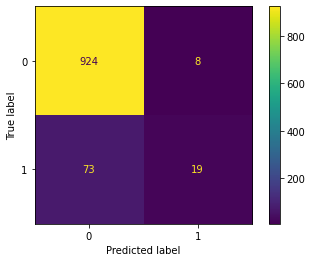

In [14]:
from sklearn.linear_model import LogisticRegression

# creating a pipeline for Logistic Regression
lr_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    LogisticRegression()
)

lr_pipe.fit(X, y) # fitting the model
plot_confusion_matrix(lr_pipe, X_test, y_test)

### NB models

Complement Naive Bayes
Bernoulli Naive Bayes
Multinomial Naive Bayes


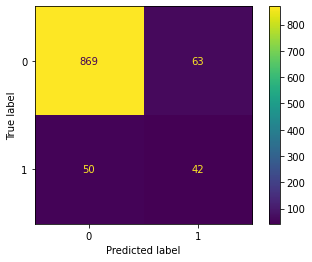

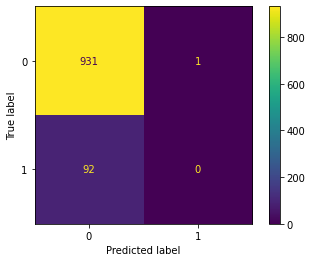

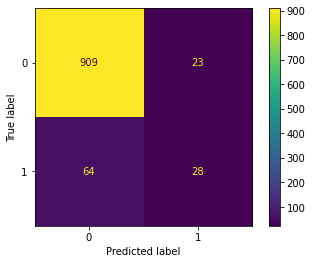

In [15]:
from sklearn.naive_bayes import ComplementNB, BernoulliNB, MultinomialNB

cnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    ComplementNB()
)

bnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    BernoulliNB()
)

mnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    MultinomialNB()
)

# fitting the models
cnb_pipe.fit(X, y)
print('Complement Naive Bayes')
plot_confusion_matrix(cnb_pipe, X_test, y_test)

bnb_pipe.fit(X, y)
print('Bernoulli Naive Bayes')
plot_confusion_matrix(bnb_pipe, X_test, y_test)

mnb_pipe.fit(X, y)
print('Multinomial Naive Bayes')
plot_confusion_matrix(mnb_pipe, X_test, y_test)

### Decision Tree

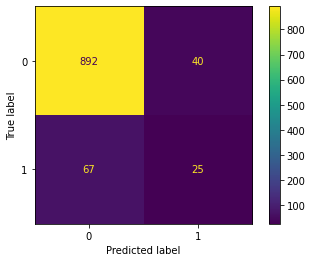

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    DecisionTreeClassifier()
)

dt_pipe.fit(X, y)
plot_confusion_matrix(dt_pipe, X_test, y_test)

### K-nearest neighbors

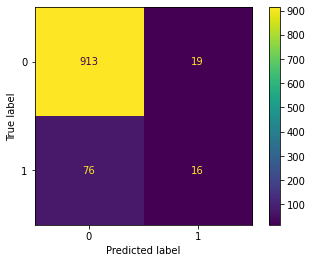

In [17]:
from sklearn.neighbors import KNeighborsClassifier

kn_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    KNeighborsClassifier()
)

kn_pipe.fit(X, y)
plot_confusion_matrix(kn_pipe, X_test, y_test)

### Perceptron

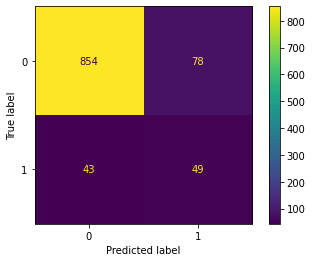

In [18]:
from sklearn.linear_model import Perceptron

p_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    Perceptron()
)

p_pipe.fit(X, y)
plot_confusion_matrix(p_pipe, X_test, y_test)

### Support Vector Machine

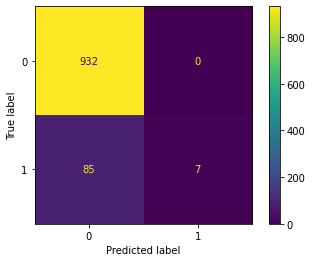

In [19]:
from sklearn.svm import SVC

svm_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    SVC()
)

svm_pipe.fit(X, y)
plot_confusion_matrix(svm_pipe, X_test, y_test)

## Comparing accuracy scores

In [20]:
# getting the accuracy scores for every model
scores = {
    'Logistic Regression': [accuracy_score(y_test, lr_pipe.predict(X_test))],
    'Complement NB': [accuracy_score(y_test, cnb_pipe.predict(X_test))],
    'Bernoulli NB': [accuracy_score(y_test, bnb_pipe.predict(X_test))],
    'Multinomail Regression': [accuracy_score(y_test, mnb_pipe.predict(X_test))],
    'Decision Tree': [accuracy_score(y_test, dt_pipe.predict(X_test))],
    'K-nearest neighbors': [accuracy_score(y_test, kn_pipe.predict(X_test))],
    'Perceptron': [accuracy_score(y_test, p_pipe.predict(X_test))],
    'SVM': [accuracy_score(y_test, svm_pipe.predict(X_test))]
}

# creating a DataFrame from the scores dictionary
scores_df = pd.DataFrame.from_dict(scores)
scores_df

,Logistic Regression,Complement NB,Bernoulli NB,Multinomail Regression,Decision Tree,K-nearest neighbors,Perceptron,SVM
0,0.920898,0.889648,0.90918,0.915039,0.895508,0.907227,0.881836,0.916992


In [21]:
# finding the best accuracy
model_name = scores_df.idxmax(axis=1)[0]
f'{model_name} : {scores_df[model_name][0]}'

'Logistic Regression : 0.9208984375'

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, lr_pipe.predict(X_test))) 

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       932
           1       0.70      0.21      0.32        92

    accuracy                           0.92      1024
   macro avg       0.82      0.60      0.64      1024
weighted avg       0.91      0.92      0.90      1024



In [23]:
from sklearn import metrics
import numpy as np

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, lr_pipe.predict(X_test)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, lr_pipe.predict(X_test)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lr_pipe.predict(X_test))))

Mean Absolute Error: 0.0791015625
Mean Squared Error: 0.0791015625
Root Mean Squared Error: 0.28125
